In [19]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Subset
import random
import numpy as np
import os
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import copy
import pickle

In [20]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [21]:
def plot_weight_histograms(model, title):
    weights = []
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            weights.append(module.weight.detach().cpu().numpy().flatten())
    plt.figure(figsize=(15, 8))
    for i, w in enumerate(weights[:11]):
        plt.subplot(5, 6, i + 1)
        plt.hist(w, bins=40, color='blue', alpha=0.7)
        plt.title(f"Layer {i+1}")
        plt.tight_layout()
    plt.suptitle(title, y=1)
    plt.show()

In [22]:
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11.classifier[6] = torch.nn.Linear(4096, 100)
vgg11.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
vgg11.load_state_dict(torch.load('models/vgg11_cifar100_baseline.pt', weights_only=True, map_location=device))
vgg11.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [23]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 256
NUM_WORKERS = 2
VAL_RATIO = 0.05

g = torch.Generator()
g.manual_seed(42)

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

def split_train_val(dataset, ratio=VAL_RATIO, generator=g):
    total_size = len(dataset)
    val_size = int(ratio * total_size)
    train_size = total_size - val_size
    return random_split(dataset, [train_size, val_size], generator=generator)

train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

train_dataset, val_dataset = split_train_val(train_dataset, VAL_RATIO, g)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform
)

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_dataset, shuffle=True)
val_loader = get_loader(val_dataset, shuffle=False)
test_loader = get_loader(test_dataset, shuffle=False)

total_test = len(test_loader.dataset)
subset_size = int(0.2 * total_test)
indices = torch.randperm(total_test, generator=g)[:subset_size]
small_test_dataset = Subset(test_loader.dataset, indices)
small_test_loader = get_loader(small_test_dataset, shuffle=False)

Training set size: 47500
Validation set size: 2500
Test set size: 10000


In [24]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [25]:
def prune_layer_unstructured_L2(model, target_layer, amount=0.3):
  if amount == 0:
    return model
  for name, module in model.named_modules():
      if name == target_layer and isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and amount > 0:
          with torch.no_grad():
              weights = module.weight.data
              num_params = weights.numel()
              num_prune = int(amount * num_params)
              if num_prune == 0:
                  continue

              # Compute L2 magnitude (same as abs for scalars)
              magnitudes = weights.abs().view(-1)
              threshold = torch.topk(magnitudes, num_prune, largest=False).values.max()

              # Zero out smallest weights
              mask = (magnitudes > threshold).float()
              module.weight.data = (weights.view(-1) * mask).view_as(weights)
          break
  return model


In [26]:
layer_names = []
for name, module in vgg11.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        layer_names.append(name)


In [27]:
prune_amts = [0,10,20,30,40,50,60,70,80,90]
sensitivity_dict = {}
for layer in layer_names:
  for perc in prune_amts:
    vgg11_copy = copy.deepcopy(vgg11)
    vg11_pruned = prune_layer_unstructured_L2(vgg11_copy, layer, perc/100)
    acc = evaluate(vg11_pruned, small_test_loader, device)
    print(f"Layer {layer} with {perc}% pruning: {acc:.2f}% Accuracy")
    sensitivity_dict[(layer, perc)] = acc

Layer features.0 with 0% pruning: 73.10% Accuracy
Layer features.0 with 10% pruning: 73.80% Accuracy
Layer features.0 with 20% pruning: 73.70% Accuracy
Layer features.0 with 30% pruning: 73.35% Accuracy
Layer features.0 with 40% pruning: 73.35% Accuracy
Layer features.0 with 50% pruning: 70.75% Accuracy
Layer features.0 with 60% pruning: 63.00% Accuracy
Layer features.0 with 70% pruning: 51.00% Accuracy
Layer features.0 with 80% pruning: 37.25% Accuracy
Layer features.0 with 90% pruning: 21.05% Accuracy
Layer features.3 with 0% pruning: 73.60% Accuracy
Layer features.3 with 10% pruning: 74.30% Accuracy
Layer features.3 with 20% pruning: 74.15% Accuracy
Layer features.3 with 30% pruning: 74.35% Accuracy
Layer features.3 with 40% pruning: 73.80% Accuracy
Layer features.3 with 50% pruning: 73.65% Accuracy
Layer features.3 with 60% pruning: 73.50% Accuracy
Layer features.3 with 70% pruning: 73.15% Accuracy
Layer features.3 with 80% pruning: 72.25% Accuracy
Layer features.3 with 90% pruning

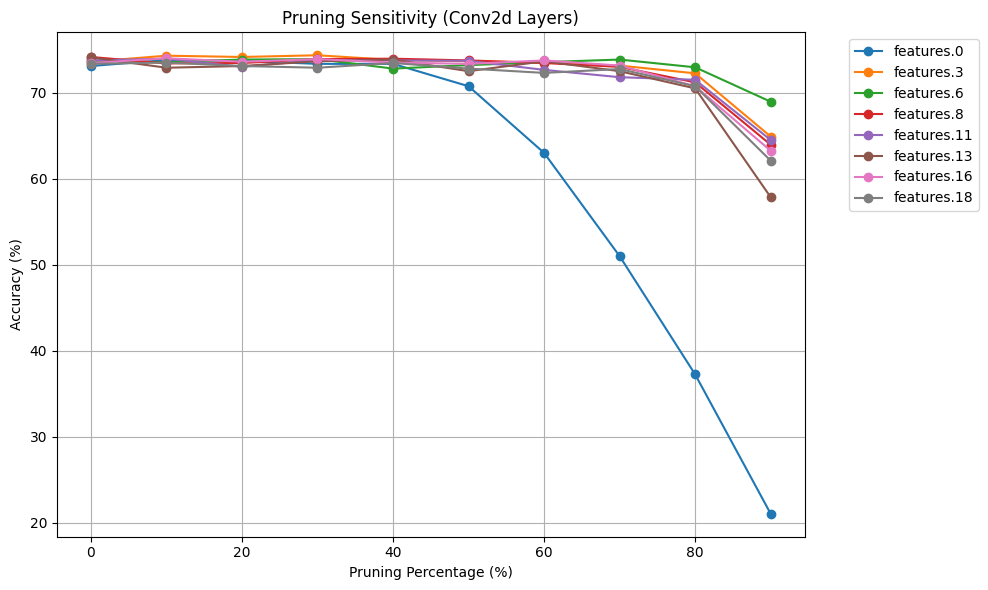

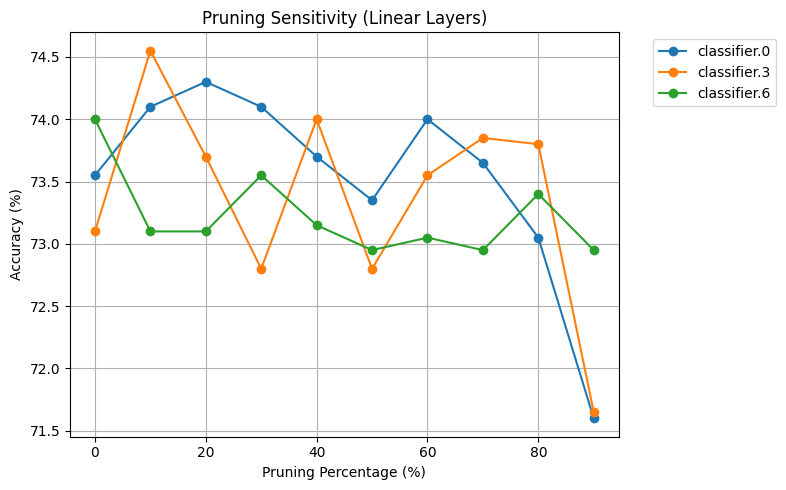

In [ ]:
# Separate conv and linear layer names
conv_layers = [name for name, module in vgg11.named_modules() if isinstance(module, torch.nn.Conv2d)]
linear_layers = [name for name, module in vgg11.named_modules() if isinstance(module, torch.nn.Linear)]

# --- Plot for Conv layers ---
plt.figure(figsize=(10, 6))
for layer in conv_layers:
    accs = [sensitivity_dict.get((layer, p), None) for p in prune_amts]
    plt.plot(prune_amts, accs, marker='o', label=layer)

plt.title("Pruning Sensitivity (Conv2d Layers)")
plt.xlabel("Pruning Percentage (%)")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot for Linear layers ---
plt.figure(figsize=(8, 5))
for layer in linear_layers:
    accs = [sensitivity_dict.get((layer, p), None) for p in prune_amts]
    plt.plot(prune_amts, accs, marker='o', label=layer)

plt.title("Pruning Sensitivity (Linear Layers)")
plt.xlabel("Pruning Percentage (%)")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Save the dictionary to a file
with open('sensitivity_dict.pkl', 'wb') as f:
    pickle.dump(sensitivity_dict, f)